# [LangGraph](https://langchain-ai.github.io/langgraph/concepts/why-langgraph/)
- LangGraph는 LLM을 사용하여 상태를 유지하고 여러 에이전트를 포함한 애플리케이션을 쉽게 만들 수 있도록 도와줍니다.
- 이 도구는 LangChain의 기능을 확장하여, 복잡한 에이전트 런타임 개발에 필수적인 순환 그래프를 만들고 관리할 수 있는 기능을 추가합니다.
- LangGraph의 핵심 개념에는 그래프 구조, 상태 관리 및 조정이 포함됩니다.

## LangGraph의 핵심 구성요소

-  Node (노드): 실제 작업을 수행하는 단위
    - 질문 분석, 답변 생성, 검색 등의 구체적인 작업
-  Edge (간선): 노드들을 순차적으로 연결
    - 데이터가 흐르는 기본 경로
- Conditional Edge: 조건에 따라 다른 경로로 분기
    - "정보가 충분한가?" 같은 판단 후 YES/NO로 갈라짐
-  State (상태): 모든 노드가 공유하는 데이터 저장소
    - 질문, 수집된 정보, 처리 상태 등을 계속 저장하고 업데이트

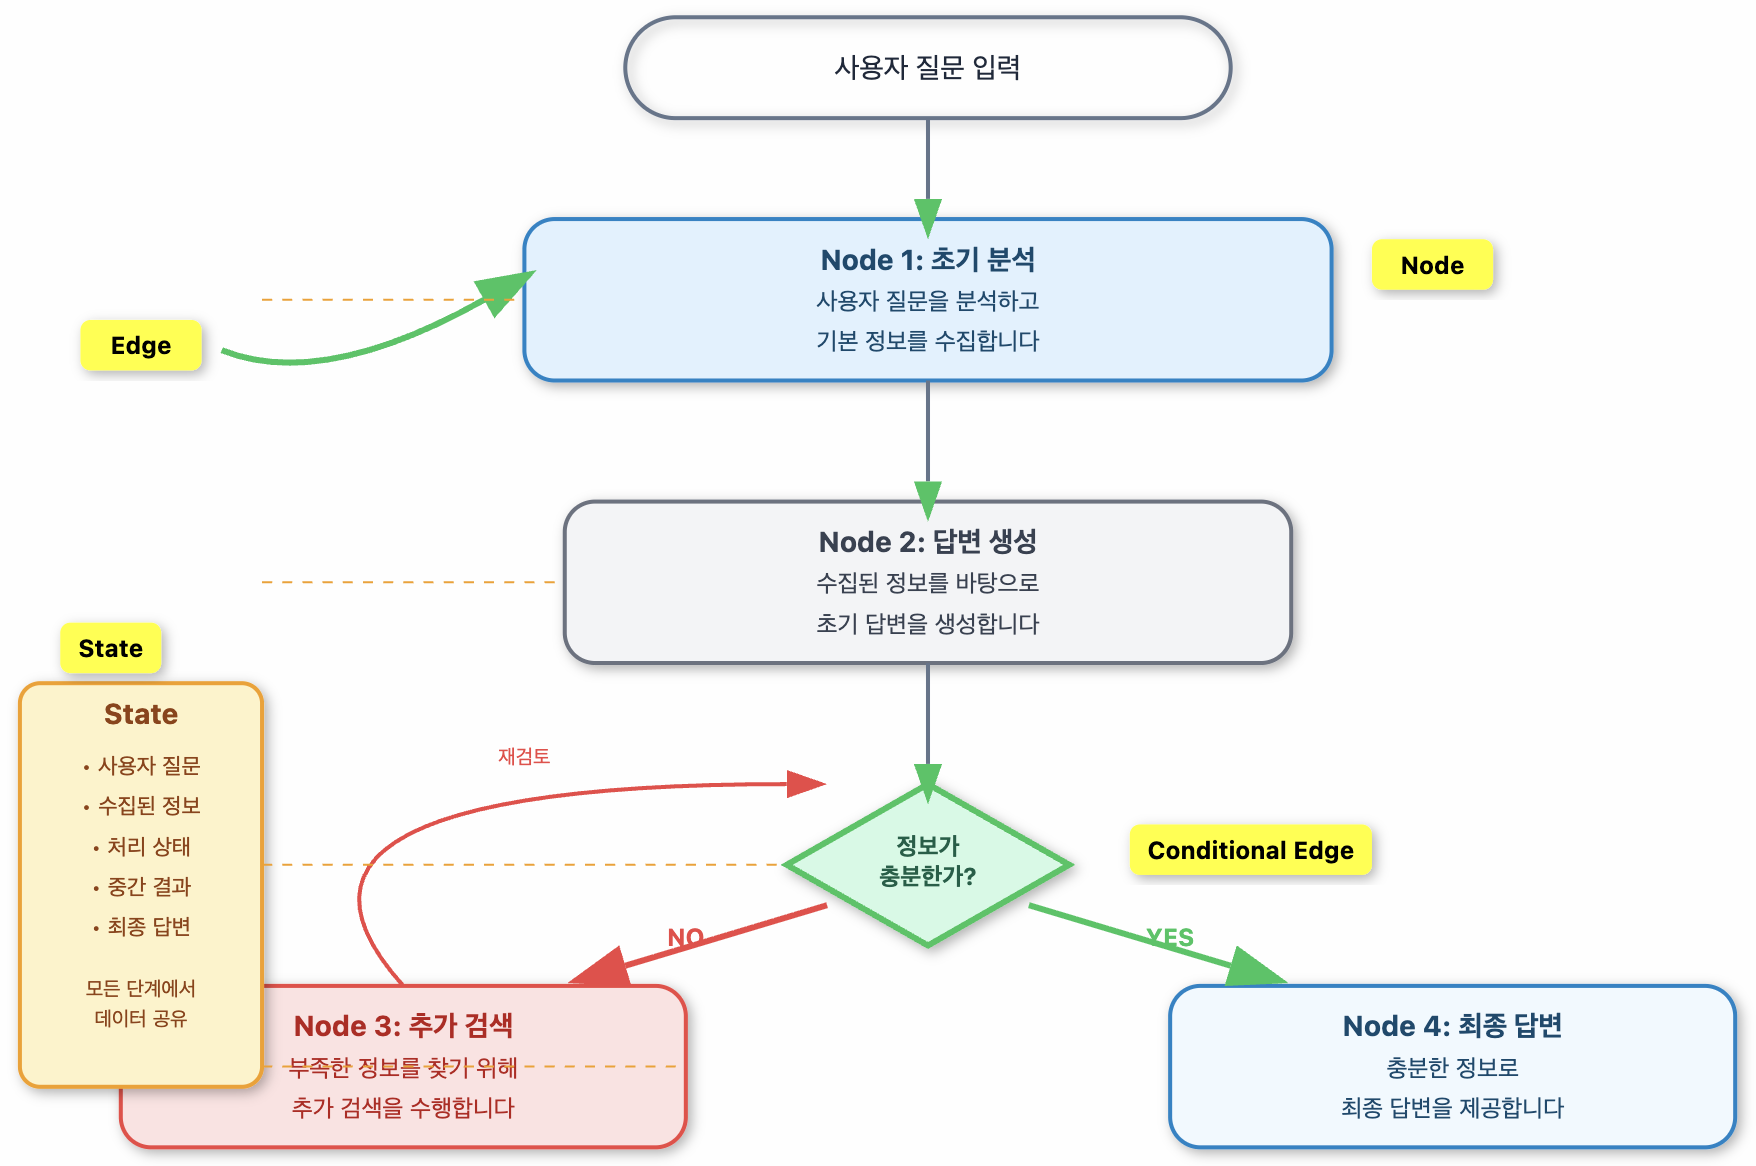

In [85]:
# 필요한 라이브러리 import
import os
from dotenv import load_dotenv

# 환경변수 로드
load_dotenv()

True

In [86]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.messages import SystemMessage
from langchain_core.prompts import HumanMessagePromptTemplate
from langchain_core.output_parsers import StrOutputParser

from langchain_openai import ChatOpenAI

# LangGraph with Tools 예제

## 1단계: 다양한 도구들 정의

In [103]:
from langchain.tools import tool
import random
from datetime import datetime, timedelta

In [104]:
@tool
def calculator(expression: str) -> str:
    """
    수학 계산을 수행하는 도구입니다.
    expression: 계산할 수식 (예: "2 + 3 * 4")
    """
    try:
        # 보안을 위해 eval 대신 간단한 계산만 허용
        allowed_chars = "0123456789+-*/.() "
        if not all(c in allowed_chars for c in expression):
            return "오류: 허용되지 않는 문자가 포함되어 있습니다."
        
        result = eval(expression)
        return f"계산 결과: {expression} = {result}"
    except Exception as e:
        return f"계산 오류: {str(e)}"

In [105]:
calculator.invoke({"expression": "2 + 3 * 4"})

'계산 결과: 2 + 3 * 4 = 14'

In [106]:
@tool
def get_weather(city: str) -> str:
    """
    도시의 날씨 정보를 조회하는 도구입니다. (시뮬레이션)
    city: 조회할 도시명
    """
    # 실제로는 날씨 API를 사용하지만, 여기서는 시뮬레이션
    weather_conditions = ["맑음", "흐림", "비", "눈", "구름많음"]
    temperature = random.randint(-10, 35)
    condition = random.choice(weather_conditions)
    
    return f"{city}의 현재 날씨: {condition}, 기온 {temperature}°C"

In [107]:
get_weather.invoke({"city": "서울"})

'서울의 현재 날씨: 구름많음, 기온 7°C'

In [108]:
from pydantic import BaseModel, Field


class ReminderInput(BaseModel):
    task: str = Field(description="할 일 내용")
    hours_from_now: int = Field(description="현재부터 몇 시간 후에 알림할지")

@tool("schedule_reminder", args_schema=ReminderInput, return_direct=True)
def schedule_reminder(task: str, hours_from_now: int) -> str:
    """
    할 일 알림을 스케줄링하는 도구입니다.
    task: 할 일 내용
    hours_from_now: 현재부터 몇 시간 후에 알림할지
    """
    reminder_time = datetime.now() + timedelta(hours=hours_from_now)
    return f"알림 설정 완료: '{task}' - {reminder_time.strftime('%Y-%m-%d %H:%M')}에 알림됩니다."

In [109]:
# Let's inspect some of the attributes associated with the tool.
print(schedule_reminder.name)
print("="*30)
print(schedule_reminder.description)
print("="*30)
print(schedule_reminder.args)
print("="*30)
print(schedule_reminder.return_direct)

schedule_reminder
할 일 알림을 스케줄링하는 도구입니다.
task: 할 일 내용
hours_from_now: 현재부터 몇 시간 후에 알림할지
{'task': {'description': '할 일 내용', 'title': 'Task', 'type': 'string'}, 'hours_from_now': {'description': '현재부터 몇 시간 후에 알림할지', 'title': 'Hours From Now', 'type': 'integer'}}
True


In [110]:
schedule_reminder.invoke({"task": "AI공부", "hours_from_now": 5})

"알림 설정 완료: 'AI공부' - 2025-08-21 22:34에 알림됩니다."

In [111]:
@tool
def search_knowledge(topic: str) -> str:
    """
    지식 베이스에서 정보를 검색하는 도구입니다. (시뮬레이션)
    topic: 검색할 주제
    """
    # 간단한 지식 베이스 시뮬레이션
    knowledge_base = {
        "파이썬": "파이썬은 1991년 귀도 반 로섬이 개발한 고급 프로그래밍 언어입니다. 문법이 간단하고 읽기 쉬워 초보자에게 인기가 높습니다.",
        "머신러닝": "머신러닝은 컴퓨터가 명시적으로 프로그래밍되지 않고도 데이터에서 패턴을 학습하는 AI의 한 분야입니다.",
        "langchain": "LangChain은 LLM 애플리케이션 개발을 위한 프레임워크로, 다양한 컴포넌트를 체인으로 연결할 수 있습니다."
    }
    
    topic_lower = topic.lower()
    for key, value in knowledge_base.items():
        if key in topic_lower:
            return f"'{topic}'에 대한 정보: {value}"
    
    return f"'{topic}'에 대한 정보를 찾을 수 없습니다. 다른 검색어를 시도해보세요."

In [112]:
search_knowledge.invoke({"topic": "langchain"})

"'langchain'에 대한 정보: LangChain은 LLM 애플리케이션 개발을 위한 프레임워크로, 다양한 컴포넌트를 체인으로 연결할 수 있습니다."

## 2단계: 도구 사용 상태 정의

In [ ]:
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict

# 2단계: 도구 사용 상태 정의
class AssistantState(TypedDict):
    """AI 개인 비서의 상태"""
    messages: Annotated[list, add_messages]
    tools_used: list  # 사용된 도구들 기록

## 3단계: 도구 목록 준비
- llm_with_tools는 상황에 따라 도구를 선택적으로 사용할 수 있습니다!

In [114]:
# 3단계: 도구 목록 준비
available_tools = [calculator, get_weather, schedule_reminder, search_knowledge]

# LLM이 도구를 사용할 수 있도록 설정
def create_llm_with_tools():
    """도구가 연결된 LLM 생성"""
    llm = ChatOpenAI(
        model="gpt-4o-mini",
        temperature=0.1  # 도구 사용시에는 낮은 온도로 정확성 향상
    )
    return llm.bind_tools(available_tools)

### calculator 테스트

In [115]:
llm_with_tools = create_llm_with_tools()

test_message1 = HumanMessage(content="15 곱하기 23은 얼마야?")
response1 = llm_with_tools.invoke([test_message1])

print("테스트 1: 계산 요청")
print(f"사용자: {test_message1.content}")
print(f"AI 응답: {response1.content}")
print(f"도구 호출 여부: {'있음' if response1.tool_calls else '없음'}")

테스트 1: 계산 요청
사용자: 15 곱하기 23은 얼마야?
AI 응답: 
도구 호출 여부: 있음


In [116]:
if response1.tool_calls:
    print("요청된 도구 호출:")
    for tool_call in response1.tool_calls:
        print(f"   - 도구명: {tool_call['name']}")
        print(f"   - 인자: {tool_call['args']}")

요청된 도구 호출:
   - 도구명: calculator
   - 인자: {'expression': '15 * 23'}


### get_weather 테스트 

In [117]:
# 테스트 2: 날씨 조회 요청
test_message2 = HumanMessage(content="부산 날씨 알려줘")
response2 = llm_with_tools.invoke([test_message2])

print("테스트 2: 날씨 조회 요청")
print(f"사용자: {test_message2.content}")
print(f"AI 응답: {response2.content}")
print(f"도구 호출 여부: {'있음' if response2.tool_calls else '없음'}")

테스트 2: 날씨 조회 요청
사용자: 부산 날씨 알려줘
AI 응답: 
도구 호출 여부: 있음


In [118]:
if response2.tool_calls:
    print("요청된 도구 호출:")
    for tool_call in response2.tool_calls:
        print(f"   - 도구명: {tool_call['name']}")
        print(f"   - 인자: {tool_call['args']}")

요청된 도구 호출:
   - 도구명: get_weather
   - 인자: {'city': '부산'}


## 4단계: 노드 생성하기

In [119]:
from langchain_core.messages import ToolMessage

### AI 에이전트 노드

In [120]:
# AI 에이전트 노드
def ai_agent_node(state: AssistantState):
    """
    사용자 요청을 분석하고 필요한 도구를 사용하는 AI 에이전트
    """
    llm_with_tools = create_llm_with_tools()
    
    # 시스템 프롬프트로 역할 부여
    system_prompt = SystemMessage(content="""
    당신은 도움이 되는 AI 개인 비서입니다. 
    사용자의 요청을 분석하여 적절한 도구를 사용해 도와주세요.
    
    사용 가능한 도구들:
    - calculator: 수학 계산
    - get_weather: 날씨 조회
    - schedule_reminder: 알림 설정
    - search_knowledge: 지식 검색
    
    도구가 필요없는 일반적인 대화도 가능합니다.
    """)
    
    messages = [system_prompt] + state["messages"]
    
    print("AI 에이전트가 요청을 분석 중...")
    response = llm_with_tools.invoke(messages)
    
    # 도구 호출이 있는지 확인
    if response.tool_calls:
        print(f"{len(response.tool_calls)}개의 도구를 사용합니다:")
        for tool_call in response.tool_calls:
            print(f"   - {tool_call['name']}: {tool_call['args']}")
    else:
        print("일반 대화로 응답합니다.")
    
    return {"messages": [response]}

### 도구 실행 노드

In [121]:
# 도구 실행 노드
def tool_execution_node(state: AssistantState):
    """
    AI가 요청한 도구들을 실제로 실행하는 노드
    """
    last_message = state["messages"][-1]
    
    if not last_message.tool_calls:
        # 도구 호출이 없으면 아무것도 하지 않음
        return {"messages": []}
    
    tool_results = []
    tools_used = []
    
    # 각 도구 호출 실행
    for tool_call in last_message.tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        
        print(f"{tool_name} 실행 중... (인자: {tool_args})")
        
        # 도구 실행
        tool_function = next(tool for tool in available_tools if tool.name == tool_name)
        try:
            result = tool_function.invoke(tool_args)
            print(f"{tool_name} 실행 완료: {result}")
            
            # 도구 결과를 메시지로 저장
            tool_message = ToolMessage(
                content=result,
                tool_call_id=tool_call["id"]
            )
            tool_results.append(tool_message)
            tools_used.append(tool_name)
            
        except Exception as e:
            error_msg = f"{tool_name} 실행 오류: {str(e)}"
            print(error_msg)
            
            tool_message = ToolMessage(
                content=error_msg,
                tool_call_id=tool_call["id"]
            )
            tool_results.append(tool_message)
    
    return {
        "messages": tool_results,
        "tools_used": tools_used
    }

### 최종 응답 노드

In [122]:
# 최종 응답 노드
def final_response_node(state: AssistantState):
    """
    도구 실행 결과를 바탕으로 최종 응답을 생성하는 노드
    """
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)
    
    system_prompt = SystemMessage(content="""
    도구 실행 결과를 바탕으로 사용자에게 친근하고 도움이 되는 최종 답변을 제공하세요.
    도구 결과를 자연스럽게 해석하여 전달하고, 추가 도움이 필요한지 물어보세요.
    """)
    
    messages = [system_prompt] + state["messages"]
    response = llm.invoke(messages)
    
    print("최종 응답 생성 완료!")
    
    return {"messages": [response]}

## 5단계: 라우팅 함수

In [123]:
# 라우팅 함수
def should_use_tools(state: AssistantState) -> str:
    """도구 사용이 필요한지 판단하는 라우팅 함수"""
    last_message = state["messages"][-1]
    
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        print("라우팅: 도구 실행 필요 → 도구 실행 노드로")
        return "execute_tools"
    else:
        print("라우팅: 도구 실행 불필요 → 최종 응답으로")
        return "final_response"

## 6단계: AI 개인 비서 그래프 구성

In [124]:
# AI 개인 비서 그래프 구성
def create_ai_assistant():
    """도구를 사용하는 AI 개인 비서 그래프"""
    workflow = StateGraph(AssistantState)
    
    # 노드들 추가
    workflow.add_node("ai_agent", ai_agent_node)
    workflow.add_node("execute_tools", tool_execution_node)
    workflow.add_node("final_response", final_response_node)
    
    # 시작점
    workflow.set_entry_point("ai_agent")
    
    # 조건부 엣지: AI 에이전트 → 도구 실행 or 최종 응답
    workflow.add_conditional_edges(
        "ai_agent",
        should_use_tools,
        {
            "execute_tools": "execute_tools",
            "final_response": "final_response"
        }
    )
    
    # 도구 실행 후에는 다시 AI 에이전트로 (결과 해석을 위해)
    workflow.add_edge("execute_tools", "final_response")
    
    # 최종 응답은 종료점
    workflow.set_finish_point("final_response")
    
    return workflow.compile()

## 7단계: 그래프 확인

```
                    시작
                     |
                     v
                    ai_agent
                     |
                     v
         +-----------+-----------+
         |                       |
         v                       |
  execute_tools                  |
         |                       |
         +-----+-----+-----------+
                     |
                     v
                    final_response
                     |
                     v
                    종료
```

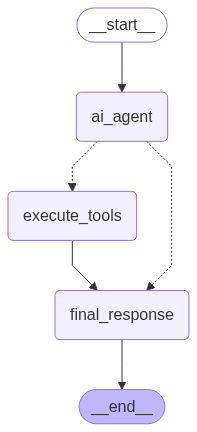

In [125]:
from IPython.display import Image, display

try:
    graph = create_ai_assistant()
    
    display(
        Image(
            graph.get_graph().draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"그래프 표시 오류: {e}")

## 8단계: 테스트 

In [126]:
assistant = create_ai_assistant()

# 각 도구를 사용하는 다양한 테스트 케이스
test_requests = [
    "125 곱하기 47이 얼마인지 계산해줘",
    "서울의 날씨가 어떤지 알려줘",
    "3시간 후에 회의 준비하라고 알림 설정해줘",
    "파이썬에 대해서 알려줘",
    "안녕! 오늘 기분이 좋아",
]

for i, request in enumerate(test_requests, 1):
    print(f"\n요청 {i}: {request}")
    print("-" * 50)
    
    result = assistant.invoke({
        "messages": [HumanMessage(content=request)],
        "tools_used": []
    })
    
    print(f"사용된 도구: {result.get('tools_used', [])}")
    print(f"최종 답변: {result['messages'][-1].content}")
    print("="*60)


요청 1: 125 곱하기 47이 얼마인지 계산해줘
--------------------------------------------------
AI 에이전트가 요청을 분석 중...
1개의 도구를 사용합니다:
   - calculator: {'expression': '125 * 47'}
라우팅: 도구 실행 필요 → 도구 실행 노드로
calculator 실행 중... (인자: {'expression': '125 * 47'})
calculator 실행 완료: 계산 결과: 125 * 47 = 5875
최종 응답 생성 완료!
사용된 도구: ['calculator']
최종 답변: 125 곱하기 47은 5875입니다! 다른 질문이나 도움이 더 필요하신가요?

요청 2: 서울의 날씨가 어떤지 알려줘
--------------------------------------------------
AI 에이전트가 요청을 분석 중...
1개의 도구를 사용합니다:
   - get_weather: {'city': '서울'}
라우팅: 도구 실행 필요 → 도구 실행 노드로
get_weather 실행 중... (인자: {'city': '서울'})
get_weather 실행 완료: 서울의 현재 날씨: 비, 기온 17°C
최종 응답 생성 완료!
사용된 도구: ['get_weather']
최종 답변: 서울의 현재 날씨는 비가 오고 있으며, 기온은 17°C입니다. 우산을 챙기시는 것이 좋겠네요! 더 궁금한 점이나 다른 정보가 필요하신가요?

요청 3: 3시간 후에 회의 준비하라고 알림 설정해줘
--------------------------------------------------
AI 에이전트가 요청을 분석 중...
1개의 도구를 사용합니다:
   - schedule_reminder: {'task': '회의 준비', 'hours_from_now': 3}
라우팅: 도구 실행 필요 → 도구 실행 노드로
schedule_reminder 실행 중... (인자: {'task': '회의 준비', 'hours